In [1]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.io import wavfile # get the api
import numpy as np
import tqdm
import os


# See https://newt.phys.unsw.edu.au/jw/notes.html

NOTE_NAMES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

def freq_to_midi(f): return 69 + 12*np.log2(f/440.0) # Pitch is often given by MIDI number
def midi_to_freq(n): return 440 * 2.0**((n-69)/12.0) # MIDI back to Frequency
def note_name(n): return NOTE_NAMES[n % 12] + str(int(n/12 - 1)) # Gives Detailed Note i.e. G3



In [15]:
# Grabbing file path

TRACKS_DIR = os.path.join(os.getcwd(), "tracks")
#AUDIO_FILE = os.path.join(TRACKS_DIR, "piano_c_major_scale.wav")
AUDIO_FILE = os.path.join(TRACKS_DIR, "140_F#m_AcstcGtr_08_103_SP.wav")
#AUDIO_FILE = os.path.join(TRACKS_DIR, "dos_gardenias.wav")

sampling_rate, data = wavfile.read(AUDIO_FILE) # load the data
audio = data.T[0] # this is a two channel soundtrack, get the first channel
AUDIO_LENGTH = len(audio)/sampling_rate # Track length in seconds 
#FIRST_FIVE_SECONDS = audio[:5*sampling_rate]
#FIRST_SECOND = audio[:1*sampling_rate]
#audio = FIRST_SECOND

#FFT_WINDOW_SEC = 0.125 # In Seconds: We're going to extract most pronounced notes from every 0.250 second window
#FFT_WINDOW_SEC = 0.001
FFT_WINDOW_SEC = 0.125
FFT_WINDOW_SIZE = int(sampling_rate * FFT_WINDOW_SEC) # In Data Points - How many data points in each FFT window

FREQ_MIN = 10 # Mininum Frequency to display
FREQ_MAX = 4200 # Maximum frequency to display
TOP_N_NOTES = 3


# In this context - A Frame is just an FFT Window
FRAMES_PER_SEC = int(1/FFT_WINDOW_SEC) # Just change to 1/window size? WINDOW SIZE Must be <= 1
FRAME_COUNT = int(AUDIO_LENGTH*FRAMES_PER_SEC) # Frames Per Sec in Video * Length of track in seconds
FRAME_OFFSET = int(len(audio)/FRAME_COUNT) # How many data points are in each frame

# Hanning window function # TODO: Do more research to understand
# "Hanning window smoothly tapers the endpoints to zero and mitigates the discontinuity that produces leakage."
window = 0.5 * (1 - np.cos(np.linspace(0, 2*np.pi, FFT_WINDOW_SIZE, False)))


/var/folders/pl/cfk0jyp10gv6kmyzdcyfnhvm0000gp/T/ipykernel_87996/2484752413.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, data = wavfile.read(AUDIO_FILE) # load the data


In [16]:
def extract_sample(audio, frame_number):
    end = frame_number * FRAME_OFFSET
    begin = int(end - FFT_WINDOW_SIZE)

    if end == 0:  # We have no audio yet, return all zeros (very beginning)
        return np.zeros((np.abs(begin)),dtype=float)
    elif begin<0: # We have some audio, pad with zeros
        return np.concatenate([np.zeros((np.abs(begin)),dtype=float),audio[0:end]])
    else:         # Usually this happens, return the next sample
        return audio[begin:end]

    
def find_max_frequency():
    mx = 0
    for frame_number in range(FRAME_COUNT):
        sample = extract_sample(audio, frame_number)
        fft = np.fft.rfft(sample * window)
        fft = np.abs(fft).real 
        mx = max(np.max(fft),mx)

    return mx

def find_top_notes(fft,num):
    if np.max(fft.real)<0.001:
        return []

    lst = [x for x in enumerate(fft.real)]
    lst = sorted(lst, key=lambda x: x[1],reverse=True)

    idx = 0
    found = []
    found_note = set()
    while( (idx<len(lst)) and (len(found)<num) ):
        f = xf[lst[idx][0]]
        y = lst[idx][1]
        n = freq_to_midi(f)
        if np.isinf(n):
            n0 = 0
        else:
            n0 = int(round(n))
        name = note_name(n0)

        if name not in found_note:
            found_note.add(name)
            s = [f,note_name(n0),y]
            found.append(s)
        idx += 1

    return found


MAX_FREQ = find_max_frequency()
fs = sampling_rate
xf = np.fft.rfftfreq(FFT_WINDOW_SIZE, 1/fs)


In [17]:
MAX_FREQ

1901858833179.723

In [18]:
import IPython.display as ipd
ipd.Audio(audio, rate=sampling_rate, autoplay=True) # load a NumPy array

In [19]:
sampling_rate

44100

In [20]:
FRAMES_PER_SEC*AUDIO_LENGTH

109.71428571428571

In [81]:
MAX_ABS_AMPLITUDE = np.max(np.absolute(audio))
ONE_100TH_MAX_AMP = int(MAX_ABS_AMPLITUDE/100)
ONE_50TH_MAX_AMP = int(MAX_ABS_AMPLITUDE/50)
ONE_20TH_MAX_AMP = int(MAX_ABS_AMPLITUDE/20)
ONE_10TH_MAX_AMP = int(MAX_ABS_AMPLITUDE/10)

print(ONE_10TH_MAX_AMP)

151997721


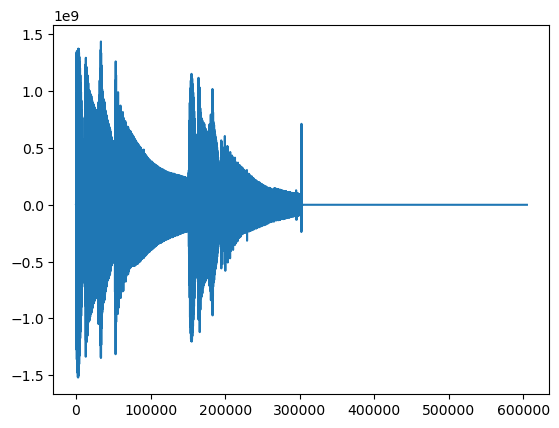

In [82]:
plt.plot(audio)

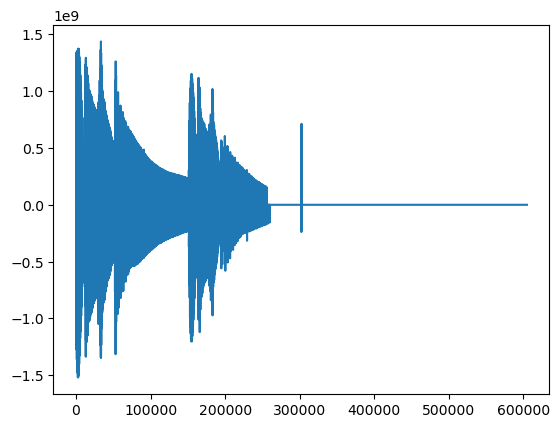

In [83]:
audio_test = audio.copy()
audio_test[np.absolute(audio_test) < ONE_10TH_MAX_AMP] = 0
plt.plot(audio_test)

In [85]:
ipd.Audio(audio_test, rate=sampling_rate, autoplay=True) # load a NumPy array

0.0


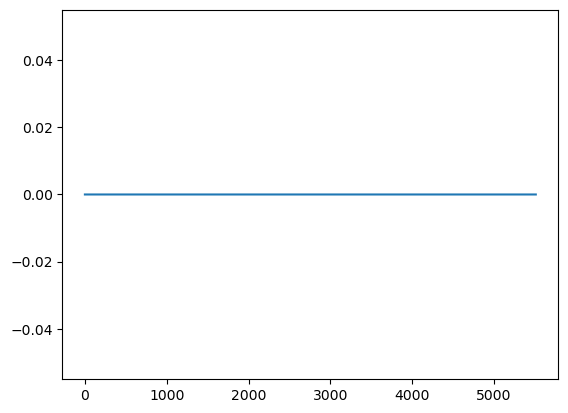

In [60]:
sample = extract_sample(audio, 57)
hanning_sample = sample*window
print(np.average(np.absolute(hanning_sample)))
plt.plot(sample*window)

In [86]:
def extract_all_notes_all_windows(audio):
    top_notes_each_window = np.array([])
    notes_by_frame_num = dict()
    for frame_number in range(FRAME_COUNT):
        #print("Frame Number:", frame_number)
        sample = extract_sample(audio, frame_number)
        fft = np.fft.rfft(sample * window)
        fft = np.abs(fft) / MAX_FREQ 
        s = find_top_notes(fft,TOP_N_NOTES)
        #print("Top Notes: ", s)
        #notes = [_[1] for _ in s]
        #top_notes_each_window = np.append(top_notes_each_window, notes)
        top_notes_each_window = np.append(top_notes_each_window, s)
        if s:
            notes_by_frame_num[frame_number] = s
        
        #if frame_number == 100:
        #    break
        
    return notes_by_frame_num


In [87]:
notes_by_frame = extract_all_notes_all_windows(audio=audio_test)

/var/folders/pl/cfk0jyp10gv6kmyzdcyfnhvm0000gp/T/ipykernel_87996/3424319068.py:14: RuntimeWarning: divide by zero encountered in log2
  def freq_to_midi(f): return 69 + 12*np.log2(f/440.0) # Pitch is often given by MIDI number


In [88]:
for k in notes_by_frame:
    print(k, notes_by_frame[k])
    print()

1 [[96.00870827285921, 'G2', 0.9997809276167052], [104.00943396226414, 'G#2', 0.6917627144868133], [88.00798258345428, 'F2', 0.3855633449668521]]

2 [[96.00870827285921, 'G2', 0.48226897008370706], [104.00943396226414, 'G#2', 0.38241835976836364], [88.00798258345428, 'F2', 0.15790066455966856]]

3 [[152.01378809869374, 'D#3', 0.6039614112329363], [144.0130624092888, 'D3', 0.5779040375628878], [136.01233671988388, 'C#3', 0.1960163719472442]]

4 [[144.0130624092888, 'D3', 0.5805366714069912], [152.01378809869374, 'D#3', 0.5194400029412686], [136.01233671988388, 'C#3', 0.1408489073073158]]

5 [[144.0130624092888, 'D3', 0.5303564972542287], [152.01378809869374, 'D#3', 0.46788024183749555], [136.01233671988388, 'C#3', 0.1309844698795974]]

6 [[152.01378809869374, 'D#3', 0.5030563688408927], [144.0130624092888, 'D3', 0.44972348247409033], [136.01233671988388, 'C#3', 0.11570285201501805]]

7 [[168.01523947750363, 'E3', 0.5564839624769492], [160.01451378809867, 'D#3', 0.5360800272743321], [176

In [ ]:
def extract_distinct_notes(audio):
    emergency_stop = 0
    all_notes_all_windows = extract_all_notes_all_windows(audio)
    distinct_notes_all_windows = dict()
    distinct_frames = sorted(list(all_notes_all_windows.keys()))
    skip = []
    
    emergency_stop_counter = 0
    emergency_stop_breakpoint = 100000
    
    frame_count = 0
    
    while frame_count < len(distinct_frames)-1:
        current_frame = distinct_frames[frame_count]
        print('current_frame', current_frame)

        current_frame_distint_notes = [_[1] for _ in all_notes_all_windows[current_frame]]
        
        next_frame = distinct_frames[frame_count+1]
        next_frame_distint_notes = [_[1] for _ in all_notes_all_windows[next_frame]]
        
        if current_frame_distint_notes != next_frame_distint_notes:
            distinct_notes_all_windows[current_frame] = current_frame_distint_notes
            distinct_notes_all_windows[next_frame] = next_frame_distint_notes
        else:
            distinct_notes_all_windows[current_frame] = current_frame_distint_notes
            while current_frame_distint_notes == next_frame_distint_notes and emergency_stop_counter < emergency_stop_breakpoint:
                frame_count += 1
                if frame_count+1 < len(distinct_frames)-1:
                    next_frame = distinct_frames[frame_count+1]
                    next_frame_distint_notes = [_[1] for _ in all_notes_all_windows[next_frame]]
                    emergency_stop_counter += 1
                else:
                    break
            
        print(frame_count)
        frame_count += 1
    
    return distinct_notes_all_windows

complete_note_seq = extract_all_notes_all_windows(audio=audio)
#print(complete_note_seq)

In [ ]:
complete_note_seq

In [ ]:
complete_note_seq

In [ ]:
complete_note_seq = extract_all_notes_all_windows(audio=hanning_audio_filtered)

In [ ]:
complete_note_seq

In [ ]:
len(audio)/sampling_rate

In [ ]:


ipd.Audio(hanning_audio, rate=sampling_rate, autoplay=True) # load a NumPy array

In [ ]:
window_2 = 0.5 * (1 - np.cos(np.linspace(0, 2*np.pi, sampling_rate, False)))
plt.plot(hanning_audio)

In [ ]:

#plt.plot(hanning_audio)


In [ ]:
len(hanning_audio)

In [ ]:
ipd.Audio(hanning_audio, rate=sampling_rate, autoplay=True) # load a NumPy array

In [ ]:
from scipy import fftpack

window_2 = 0.5 * (1 - np.cos(np.linspace(0, 2*np.pi, sampling_rate, False)))
hanning_audio = audio*window_2

max_amplitude = max(np.absolute(hanning_audio))
one_2th_max_amp = max(np.absolute(hanning_audio))/2
one_5th_max_amp = max(np.absolute(hanning_audio))/5
one_10th_max_amp = max(np.absolute(hanning_audio))/10
one_20th_max_amp = max(np.absolute(hanning_audio))/20
hanning_audio_filtered = hanning_audio.copy()
hanning_audio_filtered[np.absolute(hanning_audio_filtered) < one_2th_max_amp] = 0



signal = hanning_audio_filtered
n_frequencies = 1
threshold = 1e-3
breakpoint = 10
    
complex_zero = 0.00000000e+00+0.j
time_step = 0.00001
signal_fft = fftpack.fft(signal.copy())    
amplitude = np.abs(signal_fft)
sample_freq = fftpack.fftfreq(signal.size, d=time_step)
amplitude_frequency = np.array([amplitude, sample_freq])
peak_amplitude_positions = list()

top_n_frequencies = list()

amplitude_copy = amplitude.copy()
count = 1
while len(top_n_frequencies) < n_frequencies:
    print('Iteration', count)

    current_max = amplitude_copy.max()
    #peak_amplitude_position = amplitude_copy.argmax()
    current_max_indices = np.where(amplitude_copy == current_max)

    peak_frequency = amplitude_frequency[1, current_max_indices[0][0]]

    #print('current_max:', current_max)
    #print('positions_of_current_max:', current_max_indices)
    #print('peak_frequency:', peak_frequency)

    amplitude_copy[current_max_indices] = float(0)

    top_n_frequencies.append(peak_frequency)

    count += 1

    if count >= breakpoint:
        break

#print(top_n_frequencies)


print(top_frequencies)


In [ ]:
plt.plot(hanning_audio_filtered)

In [ ]:
top_frequencies

In [ ]:
unique, counts = np.unique(complete_note_seq, return_counts=True)

dict(zip(unique, counts))


In [ ]:
len(complete_note_seq)

In [ ]:
complete_note_seq.count()

In [ ]:
data.T[1].max()

In [ ]:
data.T[0].max()

In [ ]:
import plotly.graph_objects as go

def plot_fft(p, xf, fs, notes, dimensions=(960,540)):
    layout = go.Layout(
      title="frequency spectrum",
      autosize=False,
      width=dimensions[0],
      height=dimensions[1],
      xaxis_title="Frequency (note)",
      yaxis_title="Magnitude",
      font={'size' : 24}
    )

    fig = go.Figure(layout=layout,
                  layout_xaxis_range=[FREQ_MIN,FREQ_MAX],
                  layout_yaxis_range=[0,1]
                  )

    fig.add_trace(go.Scatter(
      x = xf,
      y = p))

    for note in notes:
        fig.add_annotation(x=note[0]+10, y=note[2],
                text=note[1],
                font = {'size' : 48},
                showarrow=False)
    return fig

In [ ]:
len(sample)

In [ ]:

#fig = plot_fft(fft.real,xf,fs,s,RESOLUTION)
#fig.show()

In [ ]:
!pip install --upgrade nbformat

In [ ]:
sample = extract_sample(audio, frame_number)
fft = np.fft.rfft(sample * window)
fft = np.abs(fft).real 
mx = max(np.max(fft),mx)

In [ ]:
mx

In [ ]:
# Plot Sample
plt.plot(sample)

In [ ]:
# Plot Sample * Window Function
plt.plot(sample*window)

In [ ]:

# Pass 1, find out the maximum amplitude so we can scale.

In [ ]:
FRAME_COUNT

In [ ]:
window

In [ ]:
FTT_WINDOW_SEC = 0.25 # In Seconds
TOP_N_NOTES = 3 # Notes to display 

# Names of the notes


SCALE = 2 # 0.5=QHD(960x540), 1=HD(1920x1080), 2=4K(3840x2160)

IMG_CONTENT_DIR = os.path.join(os.getcwd(), "content")
print(os.path.exists(AUDIO_FILE))

In [ ]:
fs, data = wavfile.read(AUDIO_FILE) # load the data
FRAME_STEP = (fs / FRAMES_PER_SEC) # audio samples per video frame

#FRAME_COUNT = int(AUDIO_LENGTH*FRAMES_PER_SEC)